In [78]:
import pandas as pd
import numpy as np
import pandas_datareader as web
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import seaborn as sns

# pypfopt packages
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.objective_functions import L2_reg

# sklearn
from sklearn.linear_model import LinearRegression

# code for the functions are shown in the final cell of the notebook

Here one can find two ways to screen stocks at a high level.
1) One can run a basket of holdings through a mean-variance optimizer to generate MSR (max sharpe ratio) and GMV (global min variance) portfolios.
* Based on past performance, one can use the outputs as a guide towards optimal stock selection.
* Typically, MSR portfolios suffer from poor diversification if one stock has shown significant returns.
* we can add an objective function to introduce a penalty factor to low holdings to allow the model to return more holdings (adjustable)

2) One can take the same holdings and generate a SML (security market line) visualization
* Here, the CAPM shows expected returns of each stocks based on its overall correlation with market and its return during that given period
* Stocks above the line have returned more than expected and are thus undervalued; below the line: undervalued

In [106]:
# set date range
t0 = dt.datetime(2020, 9, 18)
t1 = dt.date.today()

# ESPO holdings
# example of thematic ETF
# based on their initial selections, one can use the screening methods here to further narrow the selection
ESPO_holdings = ['NVDA', '0700.HK', 'SE', 'AMD', '7974.T', 
                 'ATVI', 'NTES', 'TTWO', 'BILI', 'EA',
                '7832.T', 'U', '036570.KS', 'ZNGA', '3659.T']

In [107]:
# use getpriceDF to get price df with corresponding dates
# assign to variable for later use
ESPO_price_df = getPriceDF(ESPO_holdings, t0, t1)

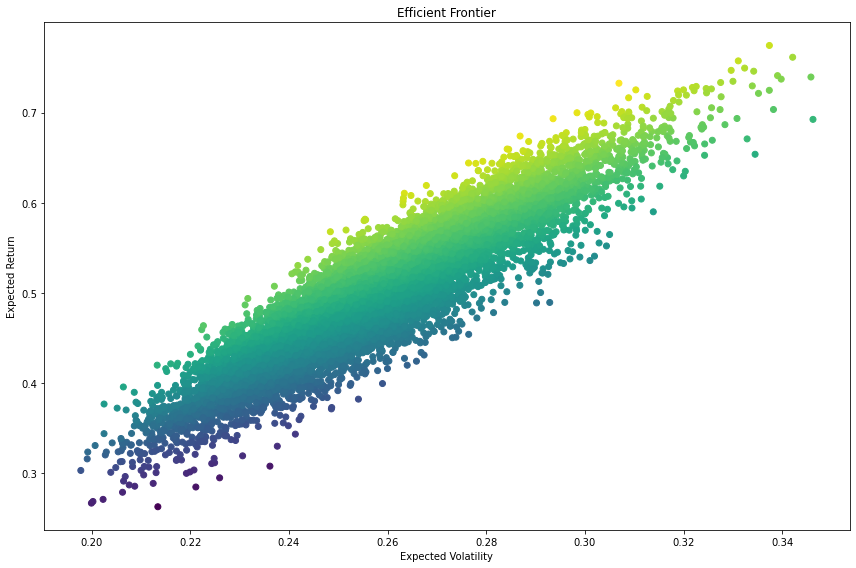

In [108]:
# use function with output price df to generate EF visualization via Monte Carlo Simulation
EfficientFrontierMCS(ESPO_price_df, 10000)

In [109]:
# use runOptimzer function on outputted price df to generate max sharpe ratio and global minimum variance portfolio
# adjust gamma of each portfolio to create penalty function; allows for more stocks to be included
# adjust gamma_MSR above 0 to get more stocks
# best practice is to leave gamma_GMV at 0, this portfolio typically has a larger number of holdings to start
# assign to variable for later use of weights generated from the optimizer
ESPO_screen_weights = runOptimzer(ESPO_price_df, gamma_MSR=1, gamma_GMV=0)

MSR Portfolio
Expected annual return: 273.6%
Annual volatility: 55.1%
Sharpe Ratio: 4.93

GMV Portfolio
Expected annual return: 19.6%
Annual volatility: 17.6%
Sharpe Ratio: 1.00


/Users/erwinremigio/anaconda3/envs/finance/lib/python3.8/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:247: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


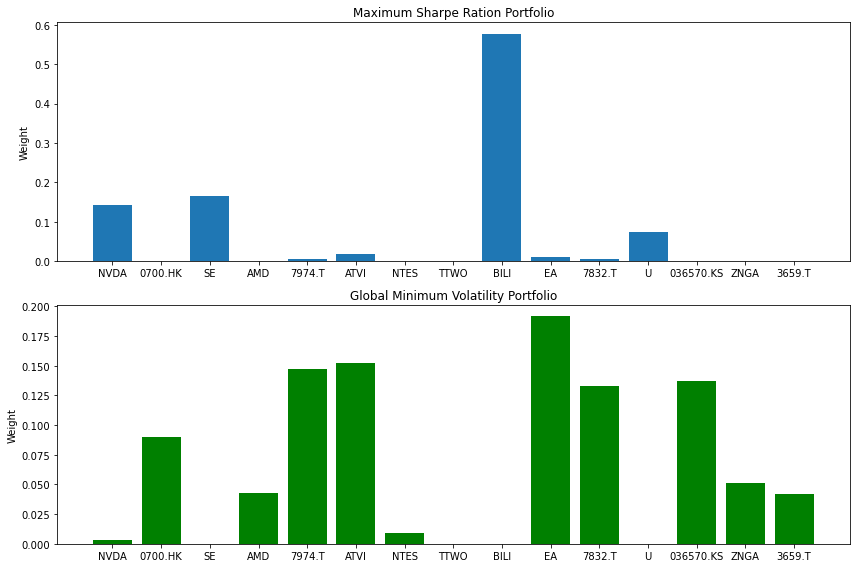

In [110]:
# use function with the outputted optimizer weights to visualize the weights chosen by the optimzer
plotScreeningWeights(ESPO_screen_weights)

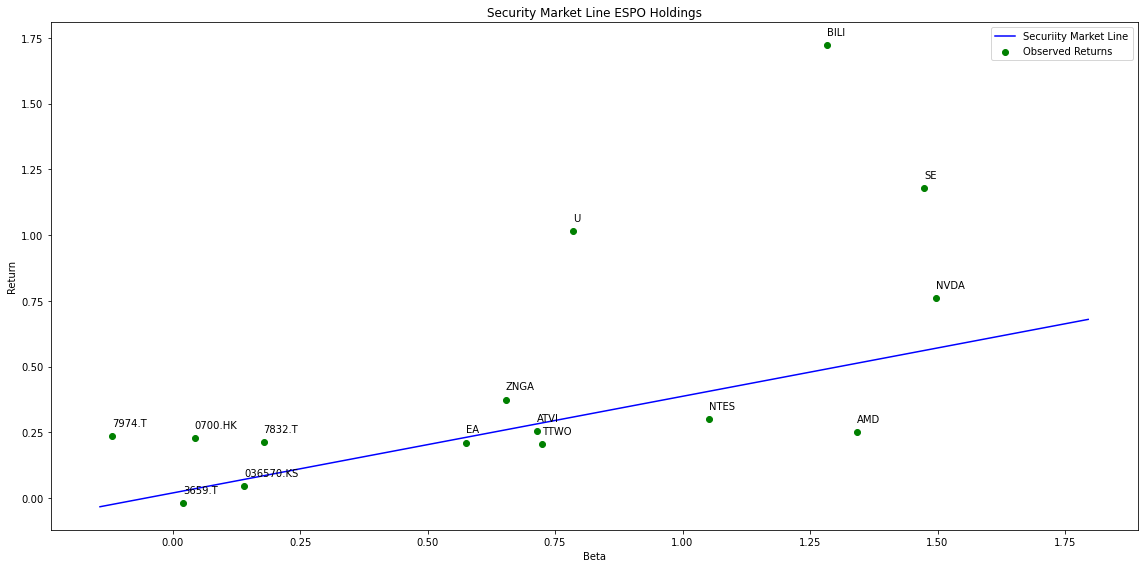

In [111]:
# generate a SML comparison to see what stocks should return based on CAPM vs what they have actually returned
# stocks above SML are undervalued, while stocks under the SML are overvalued
# set visualize=True to get graph, otherwise will only return df with beta, expected return, and observed return
# default index for beta regression is SP500 (^GSPC)

t1 = screenSML(ESPO_holdings, t0, t1, visualize=True)

In [113]:
# view of data table output from screenSML function
t1

,Beta,Expected Return,Observed Return
NVDA,1.496172,0.569725,0.761940
0700.HK,0.043543,0.035999,0.227311
SE,1.473977,0.561571,1.179155
AMD,1.342159,0.513138,0.250233
7974.T,-0.118611,-0.023580,0.237035
ATVI,0.715367,0.282841,0.254376
NTES,1.051061,0.406182,0.299254
TTWO,0.723856,0.285960,0.206286
BILI,1.282369,0.491170,1.720693
EA,0.575730,0.231535,0.211644


In [105]:
def getPriceDF(tickers, start, end):
    
    # create price df from tickers
    price_df = pd.DataFrame({
        ticker: web.get_data_yahoo(ticker, start, end)['Adj Close']
        for ticker in tickers
    }).dropna()
    
    return price_df

# define function to load tickers and create df with prices
def EfficientFrontierMCS(price_df, iterations):
    
    # visualize efficient frontier
    # number of iterations for MCS
    iters = iterations
    
    # empty arrays to store values
    pred_ret = np.zeros(len(range(iters)))
    pred_vol = np.zeros(len(range(iters)))

    # Monte Carlo Simulation to generate sample portfolios
    for i in range(iterations):
        weights = np.random.random(len(price_df.columns))
        weights /= np.sum(weights)
        pred_ret[i] = (np.sum(price_df.pct_change().dropna().mean() * weights) * 252)
        pred_vol[i] = (np.sqrt(np.dot(weights.T, np.dot(price_df.pct_change().dropna().cov() * 252, weights))))

    # visualize
    fig, ax = plt.subplots(figsize=(12,8))
    ax.set_title('Efficient Frontier')
    ax.set_xlabel('Expected Volatility')
    ax.set_ylabel('Expected Return')
    ax.scatter(pred_vol, pred_ret, c = pred_ret/pred_vol, marker='o')

    fig.tight_layout()

    plt.show()
    
def runOptimzer(price_df, gamma_MSR=0, gamma_GMV=0):

    # find mean of price data set
    mu = mean_historical_return(price_df)
    
    # shrink the covariance
    S = CovarianceShrinkage(price_df).ledoit_wolf()
    
    # max sharpe ratio portfolio (MSR)
    ef_MSR = EfficientFrontier(mu, S)
    ef_MSR.add_objective(L2_reg, gamma=gamma_MSR)
    raw_MSR = ef_MSR.max_sharpe() # optimal weights; raw data
    clean_MSR = ef_MSR.clean_weights() # clean weights for MSR
    
    #repeat for global minimum volatility portfolio (GMV)
    ef_GMV = EfficientFrontier(mu, S)
    ef_GMV.add_objective(L2_reg, gamma=gamma_GMV)
    raw_GMV = ef_GMV.min_volatility()
    clean_GMV = ef_GMV.clean_weights()
    
    # create dataframes for output
    MSR_df = pd.DataFrame.from_dict(clean_MSR, orient='index')   
    MSR_df = MSR_df.reset_index()
    MSR_df.columns = ['Ticker', 'MSR Weight']
    
    GMV_df = pd.DataFrame.from_dict(clean_GMV, orient='index')
    GMV_df = GMV_df.reset_index()
    GMV_df.columns = ['Ticker', 'GMV Weight']
    
    # portfolio performance summary
    print('MSR Portfolio')
    MSR_summary = ef_MSR.portfolio_performance(verbose=True)
    print('')
    print('GMV Portfolio')
    GMV_summary = ef_GMV.portfolio_performance(verbose=True)
    
    weights_df = MSR_df.merge(GMV_df, on='Ticker')
    
    return weights_df

def plotScreeningWeights(df):
    
    fig, ax = plt.subplots(2, figsize=(12,8))

    ax[0].set_title('Maximum Sharpe Ration Portfolio')
    ax[0].set_ylabel('Weight')
    ax[0].bar(df['Ticker'], df['MSR Weight'])

    ax[1].set_title('Global Minimum Volatility Portfolio')
    ax[1].set_ylabel('Weight')
    ax[1].bar(df['Ticker'], df['GMV Weight'], color='green')

    fig.tight_layout()
    plt.show()
    
# SML functions

def screenSML(tickers, start, end, rfr=0.02, index_comparison='^GSPC', visualize=False):

    # add index to list of tickers; will go to last position in list
    tickers = tickers + [index_comparison]
    
    # generate price list
    price_df = pd.DataFrame({
        ticker: web.get_data_yahoo(ticker, start, end)['Adj Close']
        for ticker in tickers
        }).dropna()
    
    # generate daily returns (dr_df)
    dr_df = price_df.pct_change().dropna()
    
    # X values for regression
    x_benchmark = dr_df.iloc[:, -1].values.reshape(-1,1)
    
    # generate market risk premium for this period
    MRP = (np.mean(x_benchmark) * 252) - rfr
    
    # create empty dictionary to stock beta values for each stock
    beta_dict = {}
    
    for tick in tickers[:-1]:
        y_stock = dr_df.loc[:, tick].values.reshape(-1,1)
        linear_model = LinearRegression().fit(x_benchmark, y_stock)
        beta_dict[tick] = linear_model.coef_.reshape(-1)
    
    # create dataframe to store beta and other data
    df_SML = pd.DataFrame.from_dict(beta_dict, orient='index')
    df_SML.columns = ['Beta']
    df_SML['Expected Return'] = rfr + (df_SML['Beta'] * MRP)
    df_SML['Observed Return'] = (dr_df.iloc[:, :-1].mean() * 252).values.reshape(-1,1)
    
    if visualize==True:
    
        # visualization component
        # lower and upper bounds of SML
        beta_min = 1.2 * min(df_SML['Beta'])
        beta_max = 1.2 * max(df_SML['Beta'])

        # generate SML
        SML_x = np.linspace(beta_min, beta_max, 10)
        SML_y = rfr + (SML_x * MRP)
        
        #visualize
        fig, ax = plt.subplots(figsize=(16,8))
        ax.set_title('Security Market Line ESPO Holdings')
        ax.set_xlabel('Beta')
        ax.set_ylabel('Return')
        ax.plot(SML_x, SML_y, color='blue', label='Securiity Market Line') # SML
        ax.scatter(df_SML['Beta'], df_SML['Observed Return'], color='green', label='Observed Returns') #Observed returns of each stock
        
        # labels
        
        for label, x, y in zip(df_SML.index, df_SML.loc[:, 'Beta'], df_SML.loc[:, 'Observed Return']):
            ax.annotate(label, (x,y), textcoords='offset points', xytext=(0,10))
        
        ax.legend()
        fig.tight_layout()
        plt.show()
        
    elif visualize==False:
        None
    
    else:
        None
    
    return df_SML